### Итоговая работа
### 12448/3 ИНЖДАН МГТУ им. Н.Э. Баумана
### Инженер данных (Data engineer)
### Сайфуллин Руслан Рафитович

## КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

#### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.

Иногда контракт может относиться одновременно в несколько групп.

В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

In [75]:
! pip install scikit-learn
! pip install nltk
! pip install pymorphy2
! pip install requests
! pip install gensim
! pip install pymystem3
! pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
import pandas as pd
import numpy as np

In [77]:
columns = ['id', 'contract_number', 'object_name', 'object_code', 'cost', 'contract_execution_days']
dtypes = {'id': lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_number': str, 
          'object_name': str,
          'object_code': str, 
          'cost':lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_execution_days': lambda x: pd.to_numeric(x, errors="coerce")}

In [78]:
df = pd.read_csv('datasets/dataset_clean.csv', sep=';', low_memory=False, on_bad_lines='skip')
df.shape

(14197786, 6)

In [79]:
df.describe()

,id,contract_number,object_code,cost,contract_execution_days
count,1.419779e+07,1.419779e+07,1.419724e+07,1.419779e+07,1.419779e+07
mean,1.591788e+07,2.751354e+18,3.662128e+01,2.201673e+06,2.204985e+02
std,1.029077e+07,7.006991e+17,2.251888e+01,9.988996e+07,1.534003e+02
min,1.373130e+05,1.423000e+17,1.100000e+00,1.000000e-02,1.000000e+00
25%,6.804842e+06,2.360900e+18,2.120000e+01,3.825000e+04,9.600000e+01
50%,1.489233e+07,2.772393e+18,3.310000e+01,1.497160e+05,2.000000e+02
75%,2.398329e+07,3.343301e+18,4.390000e+01,5.626637e+05,3.430000e+02
max,3.509658e+07,4.920456e+18,9.900000e+01,1.425579e+11,2.000000e+03


In [80]:
df['object_name']  = df['object_name'].astype('string')
df['object_code']  = df['object_code'].astype('string')
df.dtypes

id                                  int64
contract_number                     int64
object_name                string[python]
object_code                string[python]
cost                              float64
contract_execution_days             int64
dtype: object

In [81]:
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days
0,137313,2590229330821001063,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,21
1,137314,2590229330821001064,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,18
2,137315,2590229330821001065,"Средства лекарственные и материалы, применяемы...",21.2,342150.00,18
3,137320,2590229330821001067,"Средства лекарственные и материалы, применяемы...",21.2,26457423.22,389
4,137324,2590229330821001070,"Средства лекарственные и материалы, применяемы...",21.2,5756951.20,389


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14197786 entries, 0 to 14197785
Data columns (total 6 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   id                       int64  
 1   contract_number          int64  
 2   object_name              string 
 3   object_code              string 
 4   cost                     float64
 5   contract_execution_days  int64  
dtypes: float64(1), int64(3), string(2)
memory usage: 649.9 MB


In [83]:
grouped_data = df.groupby('object_code')['object_code'].unique()
grouped_data

object_code
1.1      [1.1]
1.2      [1.2]
1.3      [1.3]
1.4      [1.4]
1.6      [1.6]
         ...  
96.0    [96.0]
97.0    [97.0]
98.1    [98.1]
98.2    [98.2]
99.0    [99.0]
Name: object_code, Length: 272, dtype: object

По ОКПД-2 контракты в общем случае должны разделяться так:

0. Прочие
1. Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
2. Проектно-изыскательские работы (ПИР) - 41.1, 71.1
3. Подключение коммуникаций - 43.22
4. Строительный надзор – четкой группы нет. 

Строительный надзор - (43.9, 42.9, 42.2) - получил на основе ручного анализа данных. Лучше всего воспользоваться специалистом в этой предметной области.


In [84]:
query = '''object_code.str.contains("41.") or object_code.str.contains("42.") or object_code.str.contains("43.") or object_code == "71.1" '''
#and (object_code != "41.1" | object_code != "43.2")
df = df.query(query, engine='python')

In [85]:
df.describe()

,id,contract_number,cost,contract_execution_days
count,1.077891e+06,1.077891e+06,1.077891e+06,1.077891e+06
mean,1.567699e+07,3.027632e+18,1.252777e+07,1.657274e+02
std,1.027531e+07,6.623508e+17,3.005228e+08,1.649801e+02
min,1.374390e+05,3.403001e+17,1.000000e-02,1.000000e+00
25%,7.038131e+06,2.770541e+18,2.309079e+05,6.300000e+01
50%,1.441286e+07,3.240700e+18,7.909571e+05,1.210000e+02
75%,2.204623e+07,3.504506e+18,2.522650e+06,2.140000e+02
max,3.509656e+07,4.920456e+18,1.425579e+11,2.000000e+03


Очистим описания услуг от латинских символов и чисел для дальнейшего анализа данных.

In [86]:
def clear_text(text):
    lst = [char for char in text if 1039 < ord(text[0])]
    return ''.join(lst)

In [87]:
df['object_name'] = df['object_name'].apply(lambda x: clear_text(x))
df = df[df["object_name"] != ""]
df['object_name'].count()

900153

In [88]:
df.describe()

,id,contract_number,cost,contract_execution_days
count,9.001530e+05,9.001530e+05,9.001530e+05,900153.000000
mean,1.215062e+07,3.044760e+18,7.050218e+06,153.150148
std,7.133365e+06,6.505005e+17,1.685426e+08,146.767441
min,1.374390e+05,3.403001e+17,1.000000e-02,1.000000
25%,5.810018e+06,2.771570e+18,2.092741e+05,59.000000
50%,1.190011e+07,3.244301e+18,6.920000e+05,112.000000
75%,1.811065e+07,3.504601e+18,2.161987e+06,203.000000
max,2.719647e+07,4.920456e+18,1.387754e+11,2000.000000


In [89]:
df.to_csv('datasets/dataset_filter.csv', sep=';', index=False)

# NLP анализ

In [90]:
# Получим стоп слова русского языка
import nltk
from nltk.corpus import stopwords
#nltk.download()
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [91]:
# получим знаки пунктуации
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
# Создаём список шума из стопслов и знаков пунктуации
noise = stopwords.words('russian') + list(punctuation)

### Разбираем строки на токены, лематизируем и очищаем от шума (от стослов и знаков пунктуации)

In [93]:
"""from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

data = df['object_name'].values.astype('U')

# получаем список токенов
tokens = [word_tokenize(text, language="russian") for text in data]

# лематизируем полученные токены
lemma = WordNetLemmatizer()
lemma_tokens=[[lemma.lemmatize(token) for token in text] for text in tokens]

# Очищаем от шума
final_tokens=[[token for token in text if token not in noise] for text in lemma_tokens]

len(final_tokens)
"""


'from nltk.tokenize import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\n\ndata = df[\'object_name\'].values.astype(\'U\')\n\n# получаем список токенов\ntokens = [word_tokenize(text, language="russian") for text in data]\n\n# лематизируем полученные токены\nlemma = WordNetLemmatizer()\nlemma_tokens=[[lemma.lemmatize(token) for token in text] for text in tokens]\n\n# Очищаем от шума\nfinal_tokens=[[token for token in text if token not in noise] for text in lemma_tokens]\n\nlen(final_tokens)\n'

In [94]:
#Получим стоп слова русского языка
import nltk
#nltk.download()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\head\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\head\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\head\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\head\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\head\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
from nltk.corpus import wordnet as wn  # Проверить необходимость
from nltk.corpus import stopwords

#print(stopwords.words('russian'))

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

stemmer = nltk.stem.snowball.RussianStemmer()
word_lemmatized = WordNetLemmatizer()


class NLP:
  
  def __init__(self, __df):
     self.df = __df

  def tokening(self):
     self.df['data'] =  [word_tokenize(entry.lower()) for entry in self.df['object_name']]

  def lammatize(self, word, tag):
     return word_lemmatized.lemmatize(word, tag_map[tag])

  def steming(self, word_final):
     return stemmer.stem(word_final)

  def fit(self): 
    self.tokening()
    for index, entry in zip(self.df["data"].index, self.df['data']):
        final_words = []
        for word, tag in pos_tag(entry):
            if word not in stopwords.words("russian") and word.isalpha():
                word_final = self.lammatize(word, tag[0])
                word_final = self.steming(word_final)
                final_words.append(word_final)
        self.df.loc[index, "data_final"] = str(final_words)
    return self.df

nlp = NLP(df)
#df['data'] = df['object_name'].apply(lambda x: [x] )
#df['data'] = [word_tokenize(entry.lower()) for entry in df['object_name']]
vectors = nlp.fit()
vectors


C:\Users\head\AppData\Local\Temp\ipykernel_18212\3407045905.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['работ', 'строительн', 'специализирова']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df.loc[index, "data_final"] = str(final_words)


,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final
68,137439,2590407717221000153,Работы строительные специализированные,43.9,5.392656e+05,29,"[работы, строительные, специализированные]","['работ', 'строительн', 'специализирова']"
122,137528,2590421285821000134,Работы строительные специализированные,43.9,2.299470e+06,122,"[работы, строительные, специализированные]","['работ', 'строительн', 'специализирова']"
123,137529,2590421285821000135,Работы строительные специализированные,43.9,1.898112e+06,122,"[работы, строительные, специализированные]","['работ', 'строительн', 'специализирова']"
304,137827,2590500335021000676,Работы строительные специализированные,43.3,3.419140e+05,199,"[работы, строительные, специализированные]","['работ', 'строительн', 'специализирова']"
452,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1.714352e+06,383,"[услуги, в, области, архитектуры, и, инженерно...","['услуг', 'област', 'архитектур', 'проектирова..."
...,...,...,...,...,...,...,...,...
12256223,27196374,3860104675919000035,Работы строительные специализированные,43.3,1.873113e+06,211,"[работы, строительные, специализированные]","['работ', 'строительн', 'специализирова']"
12256284,27196459,3860200041119000073,Сооружения и строительные работы в области гра...,42.1,1.430199e+08,374,"[сооружения, и, строительные, работы, в, облас...","['сооружен', 'строительн', 'работ', 'област', ..."
12256285,27196462,3860200041119000074,Сооружения и строительные работы в области гра...,42.1,1.161912e+08,374,"[сооружения, и, строительные, работы, в, облас...","['сооружен', 'строительн', 'работ', 'област', ..."
12256286,27196466,3860200041119000075,Сооружения и строительные работы в области гра...,42.1,7.774969e+07,738,"[сооружения, и, строительные, работы, в, облас...","['сооружен', 'строительн', 'работ', 'област', ..."


In [96]:
vectors.to_csv('datasets/dataset_nlp_process.csv', sep=';', index=False)

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7, stop_words=stopwords.words('russian'))

X = vectors['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()
tfidf_X.shape

(900153, 14)

# Кластеризация MiniBatchKMeans

In [98]:
from sklearn.cluster import MiniBatchKMeans

#X = df_vectors.values
X = tfidf_X
kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1000, max_iter=10, n_init="auto").fit(X)
kmeans.cluster_centers_

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.52142681, 0.        ,
        0.        , 0.        , 0.42935096, 0.        , 0.52142681,
        0.        , 0.52142681, 0.        , 0.        ],
       [0.36809336, 0.36809336, 0.        , 0.        , 0.        ,
        0.36809336, 0.36809336, 0.22704835, 0.36809336, 0.        ,
        0.        , 0.        , 0.36809336, 0.36809336],
       [0.        , 0.        , 0.4472136 , 0.        , 0.89442719,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [99]:
df_cluster = df[['object_name', 'object_code', 'cost', 'contract_execution_days']].copy()
df_cluster['cluster'] = kmeans.labels_
df_cluster.head(100)

,object_name,object_code,cost,contract_execution_days,cluster
68,Работы строительные специализированные,43.9,539265.60,29,0
122,Работы строительные специализированные,43.9,2299469.98,122,0
123,Работы строительные специализированные,43.9,1898111.58,122,0
304,Работы строительные специализированные,43.3,341914.00,199,0
452,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,2
...,...,...,...,...,...
6382,Работы строительные специализированные,43.2,2261673.60,18,0
6458,Работы строительные специализированные,43.3,349851.95,24,0
6479,Работы строительные специализированные,43.2,258000.00,395,0
6502,Работы строительные специализированные,43.2,1740891.56,18,0


In [100]:
df_cluster['cluster'].value_counts()

cluster
0    401897
1    268637
2    128179
3    101440
Name: count, dtype: int64

<Axes: >

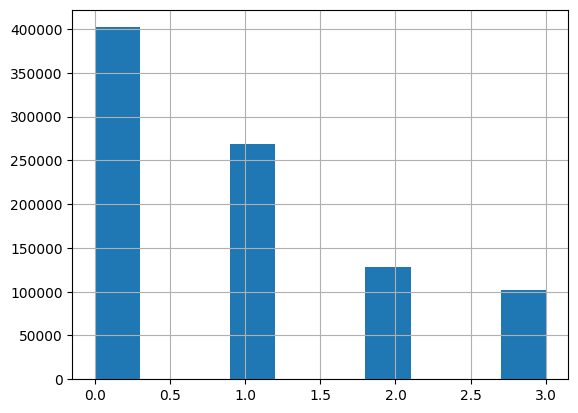

In [101]:
df_cluster['cluster'].hist()

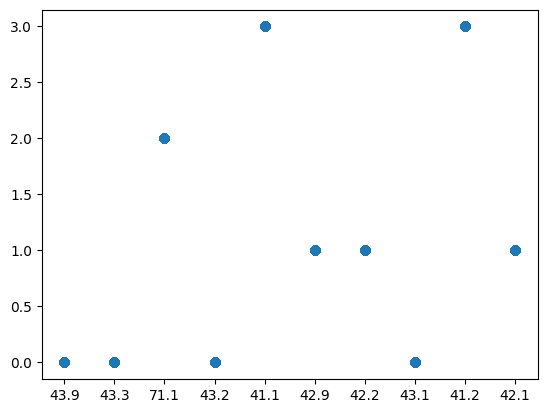

In [102]:
import matplotlib.pyplot as plt

plt.scatter(df_cluster['object_code'], df_cluster['cluster']) 
plt.show()

По ОКПД-2 контракты в общем случае должны разделяться так:

1. Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
2. Проектно-изыскательские работы (ПИР) - 41.1, 71.1
3. Подключение коммуникаций - 43.22
4. Строительный надзор – четкой группы нет. 

Строительный надзор - (43.9, 42.9, 42.2, 43.2) - получил на основе ручного анализа данных. Лучше всего воспользоваться специалистом в этой предметной области.


In [103]:
clusters = df_cluster['cluster'].unique()

comparisons = {}
for cluster in  clusters:
    codes = df_cluster[df_cluster['cluster']==cluster].groupby(['object_code']).count()['object_name']
    comparisons[cluster] = codes.index

comparisons



{0: Index(['43.1', '43.2', '43.3', '43.9'], dtype='string', name='object_code'),
 2: Index(['71.1'], dtype='string', name='object_code'),
 3: Index(['41.1', '41.2'], dtype='string', name='object_code'),
 1: Index(['42.1', '42.2', '42.9'], dtype='string', name='object_code')}

In [104]:
def get_group(x):
    for key, value in comparisons.items():
        #print(x, value)
        if x in value:            
            return key
    return 0

df_cluster['group'] = df_cluster['object_code'].apply(lambda x: get_group(x))
df_cluster.head()

,object_name,object_code,cost,contract_execution_days,cluster,group
68,Работы строительные специализированные,43.9,539265.60,29,0,0
122,Работы строительные специализированные,43.9,2299469.98,122,0,0
123,Работы строительные специализированные,43.9,1898111.58,122,0,0
304,Работы строительные специализированные,43.3,341914.00,199,0,0
452,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,2,2


In [105]:
groups = {1:{'code':['43.1', '43.2', '43.3', '43.9'], 'name':'Строительно-монтажные работы'},
               2:{'code': ['41.1', '71.1'], 'name':'Проектно-изыскательские работы'},
               3:{'code': ['43.22'], 'name':'Подключение коммуникаций'},
               4:{'code': ['43.9, 42.9, 42.2, 43.2'], 'name':'Строительный надзор'},
              }
def get_cluster_name(x):
    return groups[x]['name']

#df_cluster['cluster_name'] =  df_cluster['cluster'].apply(lambda x: get_cluster_name(x) )

In [106]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    #if (match('41', value) or match('42', value) or match('43', value)) and  (value != '41.1' or value !='43.22' or value !='42.2' or value !='42.9'):  
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9', '42.9', '42.2', '43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

In [107]:
df_cluster['group'] = df_cluster['object_code'].apply(lambda x: get_group(x))
df_cluster.head()

,object_name,object_code,cost,contract_execution_days,cluster,group
68,Работы строительные специализированные,43.9,539265.60,29,0,Строительный надзор
122,Работы строительные специализированные,43.9,2299469.98,122,0,Строительный надзор
123,Работы строительные специализированные,43.9,1898111.58,122,0,Строительный надзор
304,Работы строительные специализированные,43.3,341914.00,199,0,Строительно-монтажные работы
452,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,2,Проектно-изыскательские работы


In [108]:
df_cluster.groupby(['group','cluster', 'object_code']).count() 

object_name    cost  \
group                          cluster object_code                        
Подключение коммуникаций       0       43.2              166377  166377   
Проектно-изыскательские работы 2       71.1              128179  128179   
                               3       41.1                7203    7203   
Строительно-монтажные работы   0       43.1               20794   20794   
                                       43.3              100696  100696   
                               1       42.1              185144  185144   
                               3       41.2               94237   94237   
Строительный надзор            0       43.9              114030  114030   
                               1       42.2               30753   30753   
                                       42.9               52740   52740   

                                                    contract_execution_days  
group                          cluster object_code                           
Подключение коммуникаций       0       43.2                          166377  
Проектно-изыскательские работы 2       71.1                          128179  
                               3       41.1                            7203  
Строительно-монтажные работы   0       43.1                           20794  
                                       43.3                          100696  
                               1       42.1                          185144  
                               3       41.2                           94237  
Строительный надзор            0       43.9                          114030  
                               1       42.2                           30753  
                                       42.9                           52740

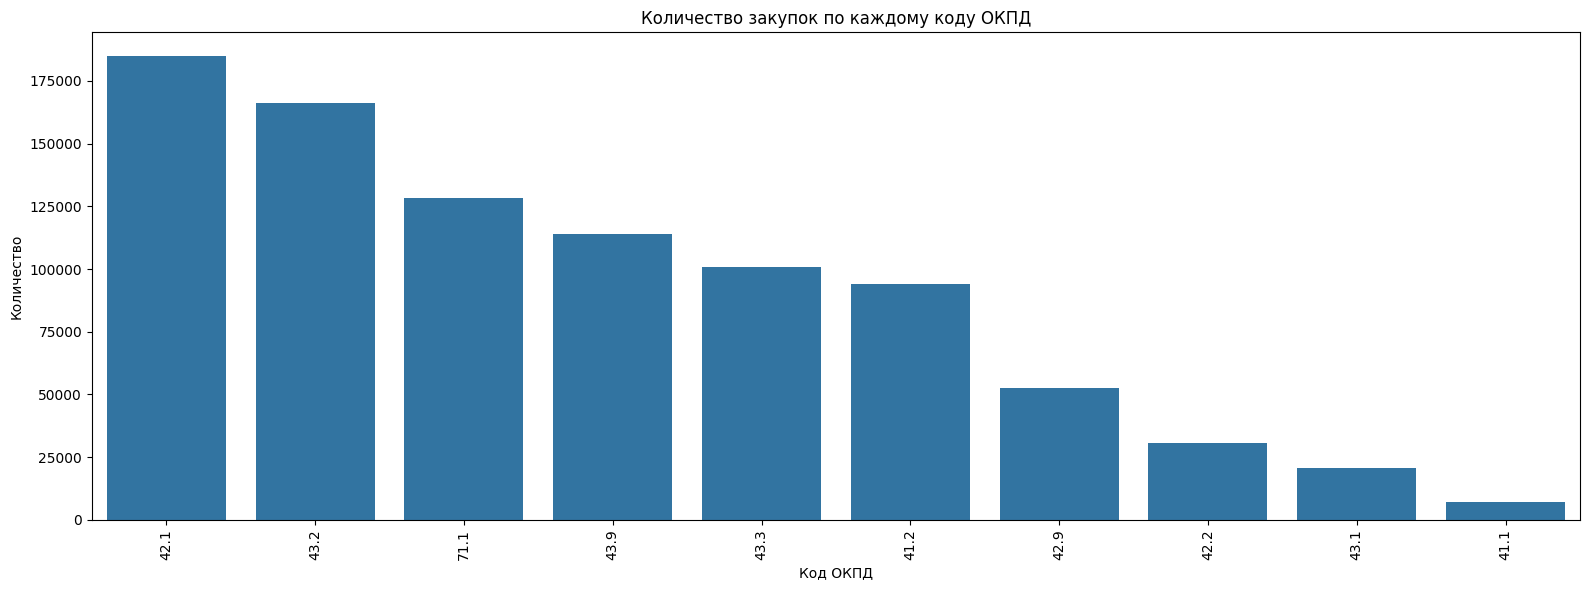

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df_cluster, x='object_code', order=df_cluster['object_code'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

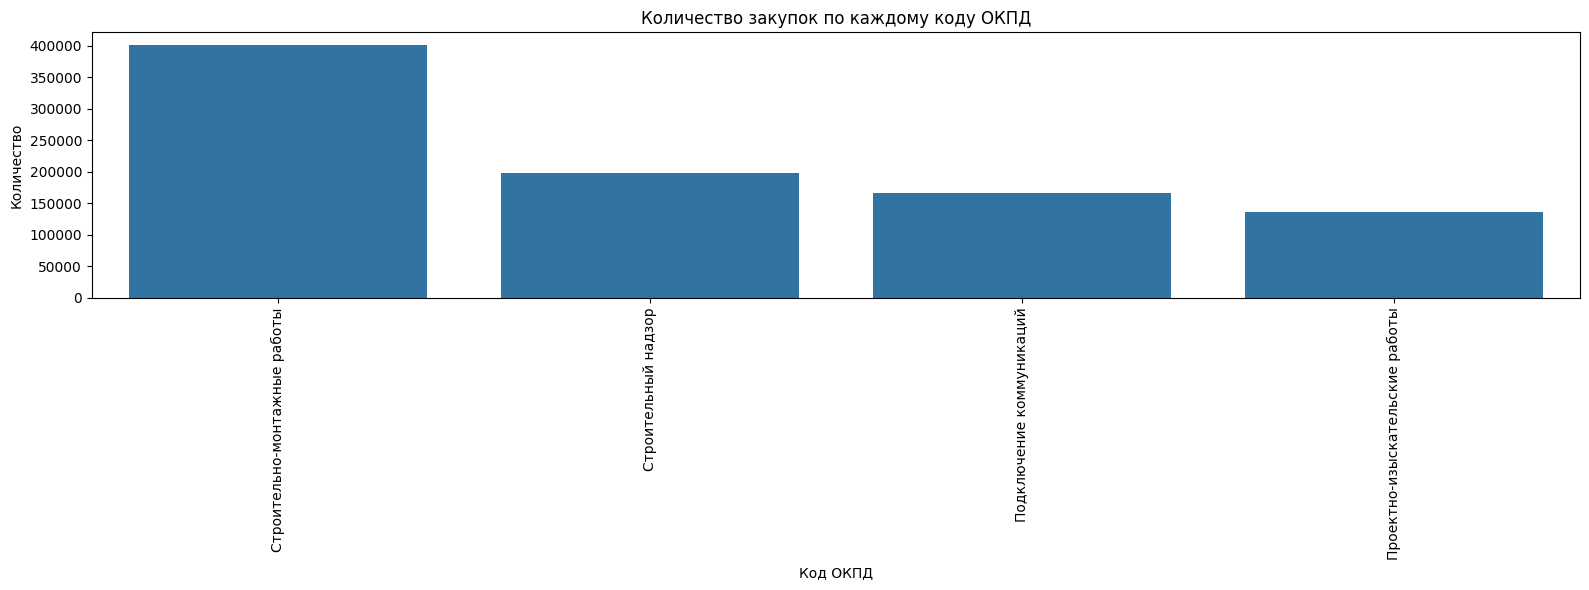

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df_cluster, x='group', order=df_cluster['group'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [111]:
grouped_data_int = df_cluster.groupby('cluster').agg(
    max_price=('cost', 'max'),
    avg_price=('cost', 'mean'),
    min_price=('cost', 'min'),
    max_duration=('contract_execution_days', 'max'),
    avg_duration=('contract_execution_days', 'mean'),
    min_duration=('contract_execution_days', 'min')).reset_index()
grouped_data_int

,cluster,max_price,avg_price,min_price,max_duration,avg_duration,min_duration
0,0,3.573347e+09,2.043131e+06,0.01,1993,136.621582,1
1,1,1.387754e+11,1.438522e+07,0.01,1987,153.580959,1
2,2,6.943426e+09,2.739999e+06,0.01,2000,200.120776,1
3,3,3.573493e+10,1.290944e+07,0.01,1976,158.142271,1


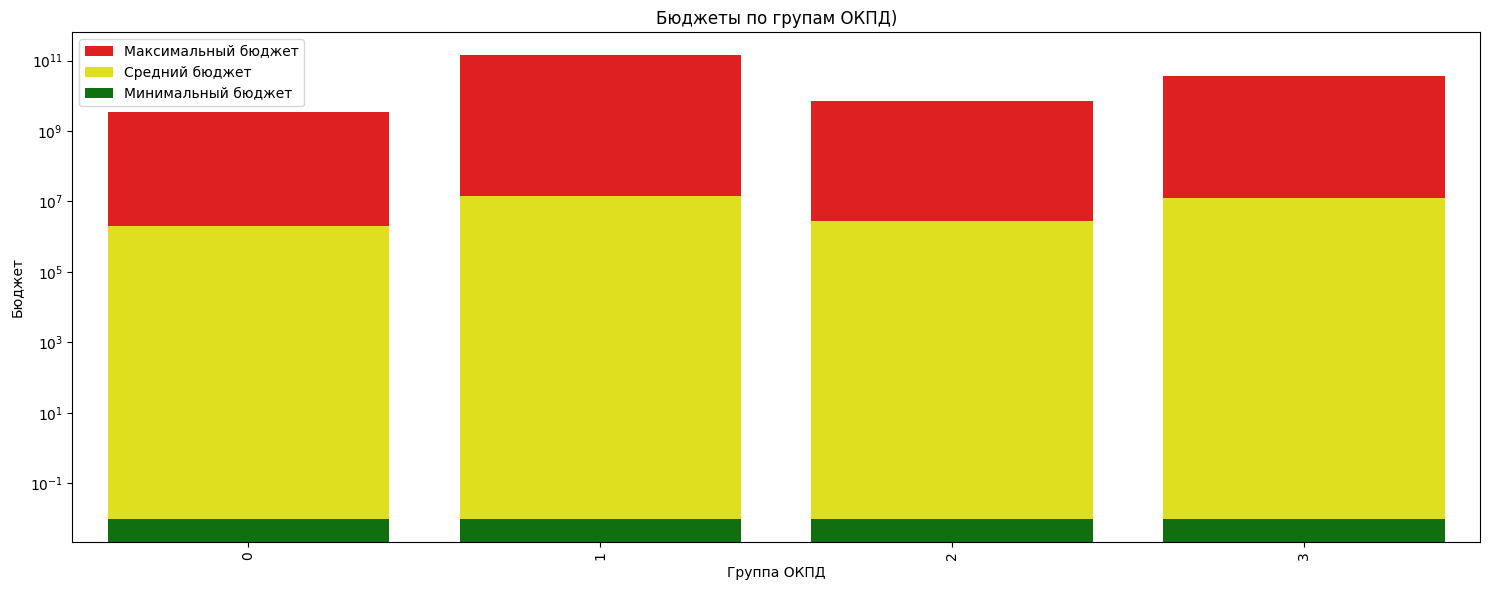

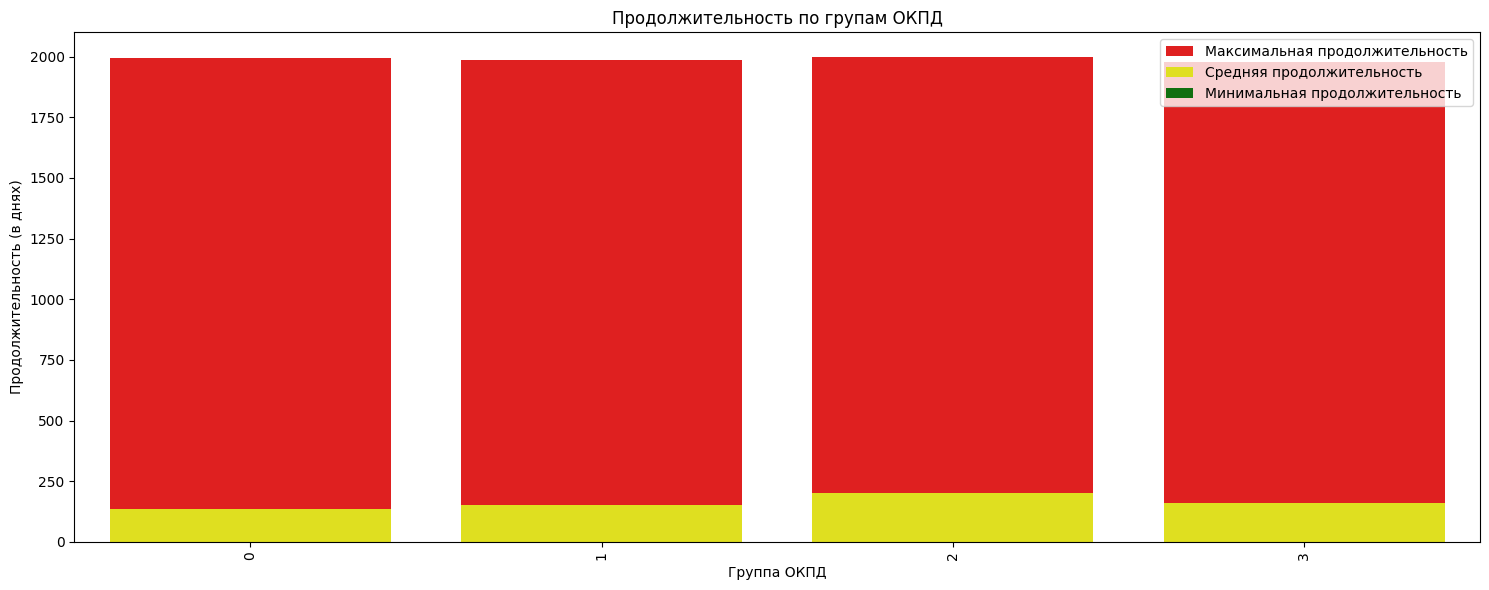

In [112]:
plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='cluster', y='max_price', color='red', label='Максимальный бюджет')
sns.barplot(data=grouped_data_int, x='cluster', y='avg_price', color='yellow', label='Средний бюджет')
sns.barplot(data=grouped_data_int, x='cluster', y='min_price', color='green', label='Минимальный бюджет')
plt.title('Бюджеты по групам ОКПД)')
plt.xlabel('Группа ОКПД')
plt.ylabel('Бюджет')
plt.legend()
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='cluster', y='max_duration', color='red', label='Максимальная продолжительность')
sns.barplot(data=grouped_data_int, x='cluster', y='avg_duration', color='yellow', label='Средняя продолжительность')
sns.barplot(data=grouped_data_int, x='cluster', y='min_duration', color='green', label='Минимальная продолжительность')
plt.title('Продолжительность по групам ОКПД')
plt.xlabel('Группа ОКПД')
plt.ylabel('Продолжительность (в днях)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [113]:
df_cluster[df_cluster['object_code'] == '43.2']

,object_name,object_code,cost,contract_execution_days,cluster,group
972,Работы строительные специализированные,43.2,50602.00,29,0,Подключение коммуникаций
1052,Работы строительные специализированные,43.2,465412.33,150,0,Подключение коммуникаций
1150,Работы строительные специализированные,43.2,221726.00,23,0,Подключение коммуникаций
1194,Работы строительные специализированные,43.2,225780.36,419,0,Подключение коммуникаций
1332,Работы строительные специализированные,43.2,487025.14,43,0,Подключение коммуникаций
...,...,...,...,...,...,...
12255343,Работы строительные специализированные,43.2,510011.00,127,0,Подключение коммуникаций
12255365,Работы строительные специализированные,43.2,6015453.72,346,0,Подключение коммуникаций
12255530,Работы строительные специализированные,43.2,965185.91,365,0,Подключение коммуникаций
12255569,Работы строительные специализированные,43.2,1579062.34,84,0,Подключение коммуникаций


In [114]:
df_cluster[df_cluster['object_code']=='71.1']

,object_name,object_code,cost,contract_execution_days,cluster,group
452,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,2,Проектно-изыскательские работы
836,Услуги в области архитектуры и инженерно-техни...,71.1,75860.97,364,2,Проектно-изыскательские работы
1781,Услуги в области архитектуры и инженерно-техни...,71.1,4014878.73,129,2,Проектно-изыскательские работы
4011,Услуги в области архитектуры и инженерно-техни...,71.1,143250.00,55,2,Проектно-изыскательские работы
4017,Услуги в области архитектуры и инженерно-техни...,71.1,9900000.00,21,2,Проектно-изыскательские работы
...,...,...,...,...,...,...
12255356,Услуги в области архитектуры и инженерно-техни...,71.1,374395.00,163,2,Проектно-изыскательские работы
12255428,Услуги в области архитектуры и инженерно-техни...,71.1,8500000.00,251,2,Проектно-изыскательские работы
12255434,Услуги в области архитектуры и инженерно-техни...,71.1,2300000.00,203,2,Проектно-изыскательские работы
12255579,Услуги в области архитектуры и инженерно-техни...,71.1,5740300.00,12,2,Проектно-изыскательские работы


In [115]:
df_cluster[df_cluster['object_code']=='43.9']

,object_name,object_code,cost,contract_execution_days,cluster,group
68,Работы строительные специализированные,43.9,539265.60,29,0,Строительный надзор
122,Работы строительные специализированные,43.9,2299469.98,122,0,Строительный надзор
123,Работы строительные специализированные,43.9,1898111.58,122,0,Строительный надзор
508,Работы строительные специализированные,43.9,849000.00,16,0,Строительный надзор
574,Работы строительные специализированные,43.9,2485000.49,298,0,Строительный надзор
...,...,...,...,...,...,...
12255429,Работы строительные специализированные,43.9,1022166.00,351,0,Строительный надзор
12255430,Работы строительные специализированные,43.9,1100000.00,259,0,Строительный надзор
12255431,Работы строительные специализированные,43.9,1375757.00,351,0,Строительный надзор
12255582,Работы строительные специализированные,43.9,6599300.00,10,0,Строительный надзор


In [116]:
df_cluster.shape

(900153, 6)

In [117]:
df_cluster.to_csv('datasets/dataset_cluster.csv', sep=';', index=False)